In [1]:
import os
import pandas as pd
import numpy as np
from scipy.stats import ttest_ind, mannwhitneyu
from matplotlib import pyplot as plt
import seaborn as sns

In [2]:
base_dir = "/mnt/Monolith/ML/kaggle/input/fake-or-real-the-impostor-hunt/data/train"
rows = []

for root, dirs, files in os.walk(base_dir):
    for file in files:
        if file.endswith(".txt"):
            file_path = os.path.join(root, file)
            with open(file_path, "r", encoding="utf-8") as f:
                content = f.read()
            rows.append({
                "article": os.path.basename(root),  # e.g., article_0000
                "filename": file,                   # e.g., file_1.txt
                "text": content                     # file contents
            })

train_df = pd.DataFrame(rows)
print(train_df.head())

        article    filename                                               text
0  article_0094  file_1.txt  The new detector system was first tested on 30...
1  article_0094  file_2.txt  The new detector system was first tested on 30...
2  article_0051  file_1.txt  From the glittering expanse of the cosmos, tal...
3  article_0051  file_2.txt  The only modification made to the system was a...
4  article_0086  file_1.txt  The formation and presence of stars in the cen...


In [3]:
train_df['text_len'] = train_df.text.apply(lambda x: len(x));
train_df.head()

,article,filename,text,text_len
0,article_0094,file_1.txt,The new detector system was first tested on 30...,1909
1,article_0094,file_2.txt,The new detector system was first tested on 30...,1935
2,article_0051,file_1.txt,"From the glittering expanse of the cosmos, tal...",1993
3,article_0051,file_2.txt,The only modification made to the system was a...,1298
4,article_0086,file_1.txt,The formation and presence of stars in the cen...,9315


In [4]:
train_df.describe()

,text_len
count,190.000000
mean,2434.494737
std,3508.617322
min,0.000000
25%,1159.500000
50%,1542.000000
75%,2110.500000
max,40316.000000


In [5]:
train_df[train_df.text_len == 0]

,article,filename,text,text_len
32,article_0014,file_1.txt,,0
45,article_0010,file_2.txt,,0


In [6]:
base_dir = "/mnt/Monolith/ML/kaggle/input/fake-or-real-the-impostor-hunt/data/test"
rows = []

for root, dirs, files in os.walk(base_dir):
    for file in files:
        if file.endswith(".txt"):
            file_path = os.path.join(root, file)
            with open(file_path, "r", encoding="utf-8") as f:
                content = f.read()
            rows.append({
                "article": os.path.basename(root),  # e.g., article_0000
                "filename": file,                   # e.g., file_1.txt
                "text": content                     # file contents
            })

test_df = pd.DataFrame(rows)
print(test_df.head())

        article    filename                                               text
0  article_1008  file_1.txt  In the central star cluster, images taken in t...
1  article_1008  file_2.txt  In the central study area of the Galactic Cent...
2  article_0094  file_1.txt  The TIMER project's large data set enables sci...
3  article_0094  file_2.txt  The TIMER project's large data set enables sci...
4  article_0526  file_1.txt  The GRAVITY instrument requires star separator...


In [7]:
test_df['text_len'] = test_df.text.apply(lambda x: len(x));
test_df.head()

,article,filename,text,text_len
0,article_1008,file_1.txt,"In the central star cluster, images taken in t...",1011
1,article_1008,file_2.txt,In the central study area of the Galactic Cent...,9527
2,article_0094,file_1.txt,The TIMER project's large data set enables sci...,1492
3,article_0094,file_2.txt,The TIMER project's large data set enables sci...,1856
4,article_0526,file_1.txt,The GRAVITY instrument requires star separator...,1311


In [8]:
test_df.describe()

,text_len
count,2136.000000
mean,2057.928839
std,2307.659326
min,0.000000
25%,1156.500000
50%,1525.000000
75%,2049.250000
max,40297.000000


In [9]:
test_df[test_df.text_len == 0]

,article,filename,text,text_len
449,article_0223,file_2.txt,,0


In [10]:
target_df = pd.read_csv("/mnt/Monolith/ML/kaggle/input/fake-or-real-the-impostor-hunt/data/train.csv")
target_df.head()

,id,real_text_id
0,0,1
1,1,2
2,2,1
3,3,2
4,4,2


In [11]:
target_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 95 entries, 0 to 94
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype
---  ------        --------------  -----
 0   id            95 non-null     int64
 1   real_text_id  95 non-null     int64
dtypes: int64(2)
memory usage: 1.6 KB


In [12]:
target_df.describe()

,id,real_text_id
count,95.000000,95.000000
mean,47.000000,1.515789
std,27.568098,0.502402
min,0.000000,1.000000
25%,23.500000,1.000000
50%,47.000000,2.000000
75%,70.500000,2.000000
max,94.000000,2.000000


In [13]:
train_df.sort_values(by=['article'], inplace = True)
train_df.reset_index(drop=True, inplace=True)
train_df.head()

,article,filename,text,text_len
0,article_0000,file_2.txt,The China relay network has released a signifi...,2018
1,article_0000,file_1.txt,The VIRSA (Visible Infrared Survey Telescope A...,2196
2,article_0001,file_1.txt,China\nThe goal of this project involves achie...,3124
3,article_0001,file_2.txt,The project aims to achieve an accuracy level ...,936
4,article_0002,file_1.txt,Scientists can learn about how galaxies form a...,1139


In [14]:
# Map article index
target_df["article"] = target_df["id"].apply(lambda x: f"article_{x:04d}")
target_df["real_filename"] = target_df["real_text_id"].apply(lambda x: f"file_{x}.txt")

# --- Merge labels ---
# Add a "label" column: 1 if filename matches real_filename, else 0
train_labeled = train_df.merge(target_df[["article", "real_filename"]],
                               on="article",
                               how="left")

train_labeled["label"] = (train_labeled["filename"] == train_labeled["real_filename"]).astype(int)

# Drop helper column if you want
train_labeled = train_labeled.drop(columns=["real_filename"])

print(train_labeled.head())

        article    filename  \
0  article_0000  file_2.txt   
1  article_0000  file_1.txt   
2  article_0001  file_1.txt   
3  article_0001  file_2.txt   
4  article_0002  file_1.txt   

                                                text  text_len  label  
0  The China relay network has released a signifi...      2018      0  
1  The VIRSA (Visible Infrared Survey Telescope A...      2196      1  
2  China\nThe goal of this project involves achie...      3124      0  
3  The project aims to achieve an accuracy level ...       936      1  
4  Scientists can learn about how galaxies form a...      1139      1  


In [15]:
# Compare average, median, std of lengths
print(train_labeled.groupby("label")["text_len"].describe())

       count         mean          std    min     25%     50%     75%      max
label                                                                         
0       95.0  3421.684211  4746.790428    0.0  1387.5  1854.0  3069.5  40316.0
1       95.0  1447.305263   499.912228  552.0  1082.0  1373.0  1691.0   2734.0


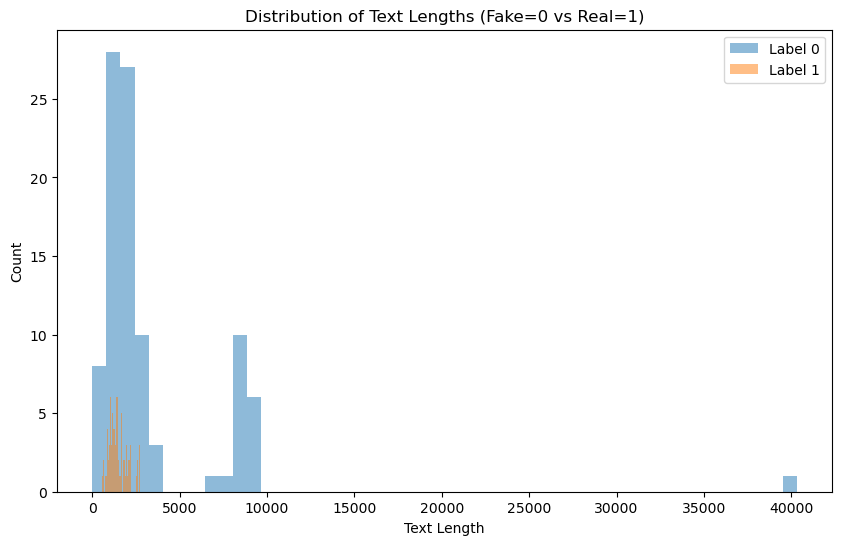

In [16]:
plt.figure(figsize=(10,6))
for lbl in [0, 1]:
    subset = train_labeled[train_labeled["label"] == lbl]
    plt.hist(subset["text_len"], bins=50, alpha=0.5, label=f"Label {lbl}")

plt.xlabel("Text Length")
plt.ylabel("Count")
plt.legend()
plt.title("Distribution of Text Lengths (Fake=0 vs Real=1)")
plt.show()

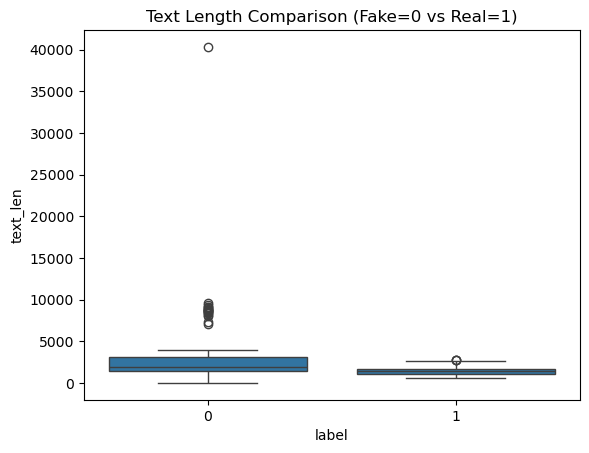

In [17]:
sns.boxplot(x="label", y="text_len", data=train_labeled)
plt.title("Text Length Comparison (Fake=0 vs Real=1)")
plt.show()

In [18]:
# Split lengths
len_real = train_labeled.loc[train_labeled["label"] == 1, "text_len"]
len_fake = train_labeled.loc[train_labeled["label"] == 0, "text_len"]

# --- Summary stats ---
summary = {
    "Real (label=1)": {
        "count": len(len_real),
        "mean": len_real.mean(),
        "median": len_real.median(),
        "std": len_real.std()
    },
    "Fake (label=0)": {
        "count": len(len_fake),
        "mean": len_fake.mean(),
        "median": len_fake.median(),
        "std": len_fake.std()
    }
}

print("\n--- Summary statistics ---")
for group, stats in summary.items():
    print(f"{group}: count={stats['count']}, "
          f"mean={stats['mean']:.1f}, median={stats['median']}, std={stats['std']:.1f}")

# --- T-test (Welch’s) ---
t_stat, p_val_t = ttest_ind(len_real, len_fake, equal_var=False)
print("\nT-test: t = %.3f, p = %.3e" % (t_stat, p_val_t))

# --- Mann-Whitney U test ---
u_stat, p_val_u = mannwhitneyu(len_real, len_fake, alternative="two-sided")
print("Mann-Whitney U: U = %.3f, p = %.3e" % (u_stat, p_val_u))


--- Summary statistics ---
Real (label=1): count=95, mean=1447.3, median=1373.0, std=499.9
Fake (label=0): count=95, mean=3421.7, median=1854.0, std=4746.8

T-test: t = -4.032, p = 1.109e-04
Mann-Whitney U: U = 2724.500, p = 2.402e-06


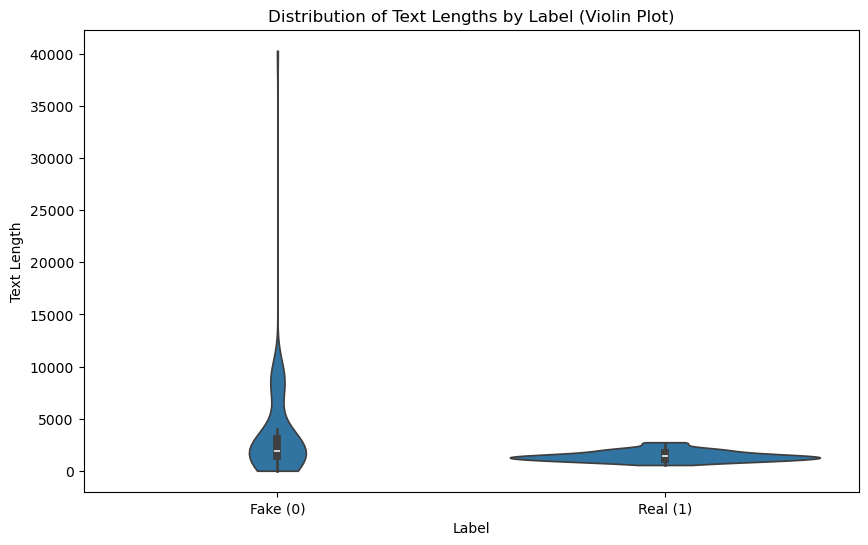

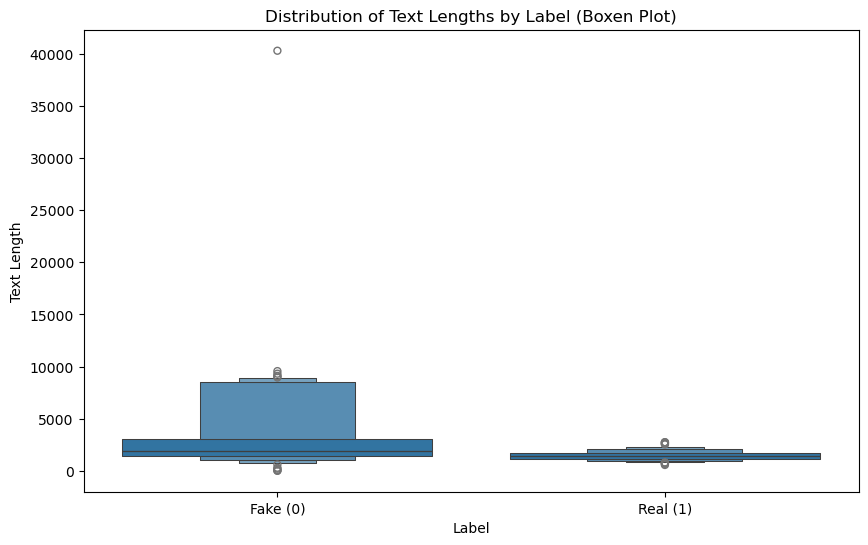

In [19]:
plt.figure(figsize=(10,6))
sns.violinplot(x="label", y="text_len", data=train_labeled, inner="box", cut=0)
plt.xticks([0, 1], ["Fake (0)", "Real (1)"])
plt.xlabel("Label")
plt.ylabel("Text Length")
plt.title("Distribution of Text Lengths by Label (Violin Plot)")
plt.show()

# Optional: boxen plot for more detailed distribution tails
plt.figure(figsize=(10,6))
sns.boxenplot(x="label", y="text_len", data=train_labeled)
plt.xticks([0, 1], ["Fake (0)", "Real (1)"])
plt.xlabel("Label")
plt.ylabel("Text Length")
plt.title("Distribution of Text Lengths by Label (Boxen Plot)")
plt.show()

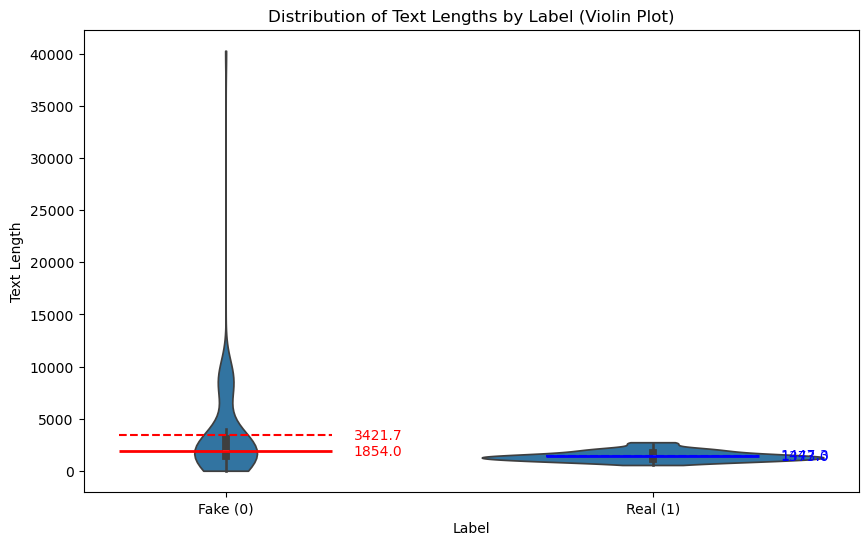

In [20]:
plt.figure(figsize=(10,6))
ax = sns.violinplot(x="label", y="text_len", data=train_labeled, inner="box", cut=0)
plt.xticks([0, 1], ["Fake (0)", "Real (1)"])
plt.xlabel("Label")
plt.ylabel("Text Length")
plt.title("Distribution of Text Lengths by Label (Violin Plot)")

# --- Overlay mean & median per label with annotations ---
for lbl, color in zip([0,1], ["red", "blue"]):
    subset = train_labeled.loc[train_labeled["label"] == lbl, "text_len"]
    mean_val = subset.mean()
    median_val = subset.median()
    
    # horizontal mean line
    plt.hlines(mean_val, xmin=lbl-0.25, xmax=lbl+0.25, 
               colors=color, linestyles="--")
    plt.text(lbl+0.3, mean_val, f"{mean_val:.1f}", color=color, va='center', fontsize=10)
    
    # horizontal median line
    plt.hlines(median_val, xmin=lbl-0.25, xmax=lbl+0.25, 
               colors=color, linestyles="-", linewidth=2)
    plt.text(lbl+0.3, median_val, f"{median_val:.1f}", color=color, va='center', fontsize=10)

plt.show()

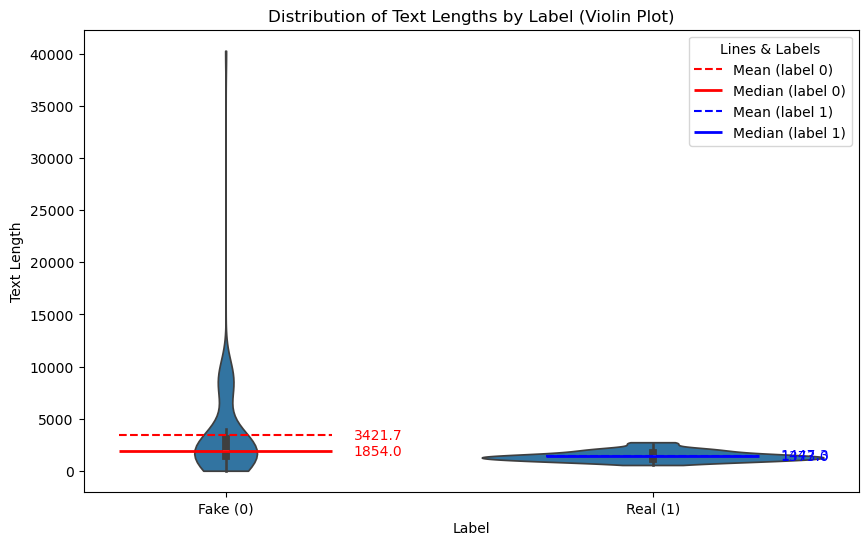

In [21]:
plt.figure(figsize=(10,6))
ax = sns.violinplot(x="label", y="text_len", data=train_labeled, inner="box", cut=0)
plt.xticks([0, 1], ["Fake (0)", "Real (1)"])
plt.xlabel("Label")
plt.ylabel("Text Length")
plt.title("Distribution of Text Lengths by Label (Violin Plot)")

# Plot mean & median with labels for legend
for lbl, color in zip([0,1], ["red", "blue"]):
    subset = train_labeled.loc[train_labeled["label"] == lbl, "text_len"]
    mean_val = subset.mean()
    median_val = subset.median()
    
    # horizontal mean line (dashed) with label for legend
    plt.hlines(mean_val, xmin=lbl-0.25, xmax=lbl+0.25, 
               colors=color, linestyles="--", label=f"Mean (label {lbl})")
    plt.text(lbl+0.3, mean_val, f"{mean_val:.1f}", color=color, va='center', fontsize=10)
    
    # horizontal median line (solid) with label for legend
    plt.hlines(median_val, xmin=lbl-0.25, xmax=lbl+0.25, 
               colors=color, linestyles="-", linewidth=2, label=f"Median (label {lbl})")
    plt.text(lbl+0.3, median_val, f"{median_val:.1f}", color=color, va='center', fontsize=10)

# Remove duplicate labels in legend
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys(), loc='upper right', title='Lines & Labels')

plt.show()

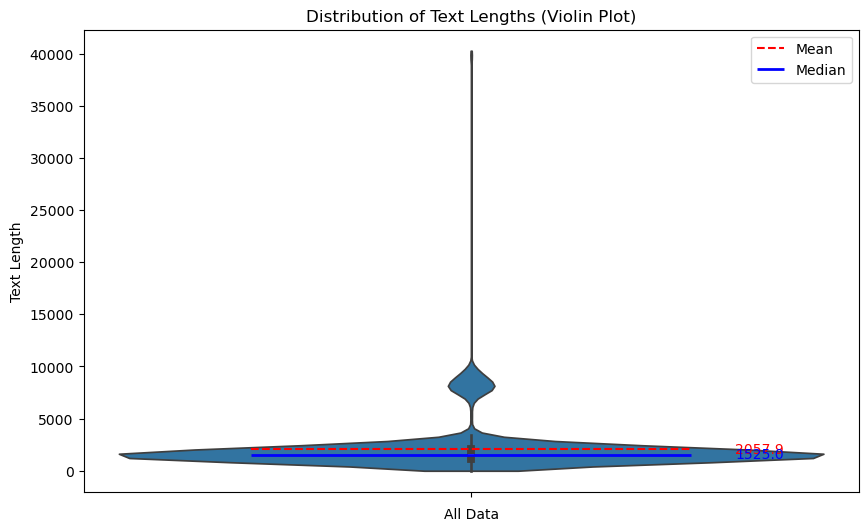

In [23]:
plt.figure(figsize=(10,6))
ax = sns.violinplot(y="text_len", data=test_df, inner="box", cut=0)
plt.xlabel("All Data")
plt.ylabel("Text Length")
plt.title("Distribution of Text Lengths (Violin Plot)")

# Add mean and median lines
mean_val = test_df["text_len"].mean()
median_val = test_df["text_len"].median()

plt.hlines(mean_val, xmin=-0.25, xmax=0.25, 
           colors="red", linestyles="--", label=f"Mean")
plt.text(0.3, mean_val, f"{mean_val:.1f}", color="red", va='center', fontsize=10)

plt.hlines(median_val, xmin=-0.25, xmax=0.25, 
           colors="blue", linestyles="-", linewidth=2, label=f"Median")
plt.text(0.3, median_val, f"{median_val:.1f}", color="blue", va='center', fontsize=10)

plt.legend(loc='upper right')
plt.show()

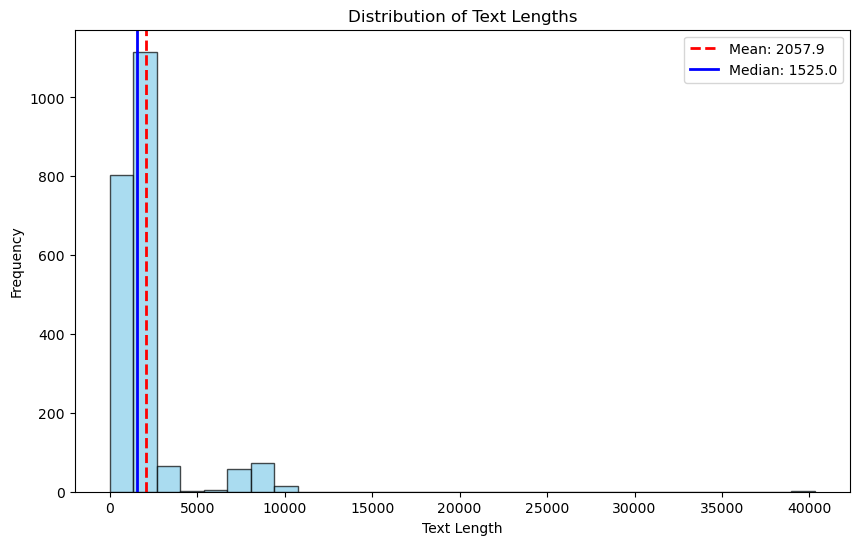

In [24]:
plt.figure(figsize=(10,6))
plt.hist(test_df['text_len'], bins=30, alpha=0.7, color='skyblue', edgecolor='black')

mean_val = test_df["text_len"].mean()
median_val = test_df["text_len"].median()

plt.axvline(mean_val, color='red', linestyle='--', linewidth=2, label=f'Mean: {mean_val:.1f}')
plt.axvline(median_val, color='blue', linestyle='-', linewidth=2, label=f'Median: {median_val:.1f}')

plt.xlabel("Text Length")
plt.ylabel("Frequency")
plt.title("Distribution of Text Lengths")
plt.legend()
plt.show()